In [131]:
import pandas as pd
import numpy as np
from env import username, password, host
import wrangle
import prepare
from scipy import stats
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Acquire

In [3]:
url = f"mysql+pymysql://{username}:{password}@{host}/zillow"
# this query brings in all the columns necessary to ask the questions posed by the zillow team  
query = """
            
SELECT parcelid, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, taxamount, assessmentyear, regionidcounty,regionidzip, transactiondate
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)

JOIN predictions_2017 USING(parcelid)

WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")
                              AND (transactiondate BETWEEN '2017-05-01' AND '2017-08-31');
                              
                              """
    
df = pd.read_sql(query, url)
df

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,transactiondate
0,12354372,2.0,1.0,756.0,83520.0,1355.47,2016.0,3101.0,96119.0,2017-05-08
1,13973867,4.0,3.0,1850.0,517000.0,6116.96,2016.0,1286.0,97004.0,2017-05-08
2,13981618,3.0,2.5,3271.0,1814378.0,19686.04,2016.0,1286.0,96978.0,2017-05-08
3,17120696,4.0,2.5,1807.0,265679.0,3150.70,2016.0,2061.0,97107.0,2017-05-08
4,12438626,4.0,3.0,2468.0,443691.0,5364.53,2016.0,3101.0,96242.0,2017-05-08
...,...,...,...,...,...,...,...,...,...,...
28119,11927617,3.0,2.0,1345.0,634832.0,7395.36,2016.0,3101.0,96517.0,2017-08-30
28120,14210331,2.0,1.5,1087.0,319000.0,3570.20,2016.0,1286.0,97063.0,2017-08-30
28121,11446352,4.0,2.0,1271.0,514037.0,5996.69,2016.0,3101.0,96162.0,2017-08-30
28122,12954981,4.0,2.0,2058.0,532592.0,6151.04,2016.0,3101.0,96524.0,2017-08-30


In [4]:
### PREARE ###

In [5]:
# I need to prepare one df for answering the questions posed and a 2nd df name df2 that is for exploring and modeling

In [6]:
df.info()
# these are all the correct datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28124 non-null  int64  
 1   bedroomcnt                    28124 non-null  float64
 2   bathroomcnt                   28124 non-null  float64
 3   calculatedfinishedsquarefeet  28077 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   taxamount                     28123 non-null  float64
 6   assessmentyear                28124 non-null  float64
 7   regionidcounty                28124 non-null  float64
 8   regionidzip                   28107 non-null  float64
 9   transactiondate               28124 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.1+ MB


Feature                             Description

'assessmentyear':	                The year of the property tax assessment 
'bathroomcnt':   	                Number of bathrooms in home including fractional bathrooms
'bedroomcnt':   	                Number of bedrooms in home 
'calculatedfinishedsquarefeet': 	Calculated total finished living area of the home 
'parcelid':                     	Unique identifier for parcels (lots) 
'regionidcounty':                	County in which the property is located
'regionidzip':                  	Zip code in which the property is located
'taxamount':                        The total property tax assessed for that assessment year
'taxvaluedollarcnt':             	The total tax assessed value of the parcel

-I chose to use the column regionidzip instead of fips because this holds the actual zipcode
-I chose to keep parcelid so I could use it as the index 
-I chose to use calculatedfinishedsquarefeet because all of the other squarefeet features did not include the amount that would be advertised with the house which would only be the finished sqft
-I brought in the assessmentyear in order to only capture homes in the year of 2017
-Last I brought in transaction date to limit the dataset to only those homes with tranactions in the "hot months" May through August

In [7]:
# here I check out all the columns I brought in to make sure I have all
# of the information necessary to answer questions posed by the team
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,transactiondate
0,12354372,2.0,1.0,756.0,83520.0,1355.47,2016.0,3101.0,96119.0,2017-05-08
1,13973867,4.0,3.0,1850.0,517000.0,6116.96,2016.0,1286.0,97004.0,2017-05-08
2,13981618,3.0,2.5,3271.0,1814378.0,19686.04,2016.0,1286.0,96978.0,2017-05-08
3,17120696,4.0,2.5,1807.0,265679.0,3150.70,2016.0,2061.0,97107.0,2017-05-08
4,12438626,4.0,3.0,2468.0,443691.0,5364.53,2016.0,3101.0,96242.0,2017-05-08


In [8]:
# here I want to get an idea of the summarized numbers
df.describe()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip
count,2.812400e+04,28124.000000,28124.000000,28077.000000,2.812300e+04,28123.000000,28124.0,28124.000000,28107.000000
mean,1.304239e+07,3.309487,2.316509,1934.930014,5.350049e+05,6508.829263,2016.0,2509.060909,96656.246629
std,3.747700e+06,0.943073,1.016983,995.684457,7.076811e+05,8221.720405,0.0,808.588534,5130.262567
min,1.071186e+07,0.000000,0.000000,240.000000,1.000000e+03,51.260000,2016.0,1286.000000,95982.000000
25%,1.151380e+07,3.000000,2.000000,1278.000000,1.986360e+05,2705.330000,2016.0,1286.000000,96208.000000
50%,1.259670e+07,3.000000,2.000000,1675.000000,3.827980e+05,4735.280000,2016.0,3101.000000,96414.000000
75%,1.414914e+07,4.000000,3.000000,2326.000000,6.327670e+05,7528.405000,2016.0,3101.000000,96995.000000
max,1.676878e+08,12.000000,11.000000,17245.000000,2.385837e+07,276797.830000,2016.0,3101.000000,399675.000000


In [9]:
# next I'll look at null values
df.isnull().sum()

parcelid                         0
bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    47
taxvaluedollarcnt                1
taxamount                        1
assessmentyear                   0
regionidcounty                   0
regionidzip                     17
transactiondate                  0
dtype: int64

In [10]:
# let's compare those to the overall numbers in the dataset to see how to handle them
df.shape

(28124, 10)

In [11]:
# the amount of null values is small enough in comparison to the overall set to delete these
# records

df = df.dropna()

In [12]:
# let's check that they are gone
df.isnull().sum()

parcelid                        0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
taxamount                       0
assessmentyear                  0
regionidcounty                  0
regionidzip                     0
transactiondate                 0
dtype: int64

In [13]:
df.shape

(28060, 10)

In [14]:
# now lets rename columns
df = df.rename(columns={
                            'parcelid': 'parcel_id',
                            'calculatedfinishedsquarefeet': 'sqft',
                            'bathroomcnt': 'baths',
                            'bedroomcnt': 'beds',
                            'assessmentyear': 'assessment_year',
                            'regionidcounty': 'county',
                            'regionidzip': 'zipcode',
                            'transactiondate': 'tranaction_date',
                            'taxvaluedollarcnt':'tax_value'})

In [15]:
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date
0,12354372,2.0,1.0,756.0,83520.0,1355.47,2016.0,3101.0,96119.0,2017-05-08
1,13973867,4.0,3.0,1850.0,517000.0,6116.96,2016.0,1286.0,97004.0,2017-05-08
2,13981618,3.0,2.5,3271.0,1814378.0,19686.04,2016.0,1286.0,96978.0,2017-05-08
3,17120696,4.0,2.5,1807.0,265679.0,3150.70,2016.0,2061.0,97107.0,2017-05-08
4,12438626,4.0,3.0,2468.0,443691.0,5364.53,2016.0,3101.0,96242.0,2017-05-08


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28060 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        28060 non-null  int64  
 1   beds             28060 non-null  float64
 2   baths            28060 non-null  float64
 3   sqft             28060 non-null  float64
 4   tax_value        28060 non-null  float64
 5   taxamount        28060 non-null  float64
 6   assessment_year  28060 non-null  float64
 7   county           28060 non-null  float64
 8   zipcode          28060 non-null  float64
 9   tranaction_date  28060 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.4+ MB


In [17]:
# change datatypes to int beds,tax_value 
df['beds'] = df['beds'].astype(int)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28060 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        28060 non-null  int64  
 1   beds             28060 non-null  int64  
 2   baths            28060 non-null  float64
 3   sqft             28060 non-null  float64
 4   tax_value        28060 non-null  float64
 5   taxamount        28060 non-null  float64
 6   assessment_year  28060 non-null  float64
 7   county           28060 non-null  float64
 8   zipcode          28060 non-null  float64
 9   tranaction_date  28060 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 2.4+ MB


In [19]:
# calculate the tax rate and make a new column/feature 
df['tax_rate']= df['taxamount']/df['tax_value']

In [20]:
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date,tax_rate
0,12354372,2,1.0,756.0,83520.0,1355.47,2016.0,3101.0,96119.0,2017-05-08,0.016229
1,13973867,4,3.0,1850.0,517000.0,6116.96,2016.0,1286.0,97004.0,2017-05-08,0.011832
2,13981618,3,2.5,3271.0,1814378.0,19686.04,2016.0,1286.0,96978.0,2017-05-08,0.010850
3,17120696,4,2.5,1807.0,265679.0,3150.70,2016.0,2061.0,97107.0,2017-05-08,0.011859
4,12438626,4,3.0,2468.0,443691.0,5364.53,2016.0,3101.0,96242.0,2017-05-08,0.012091


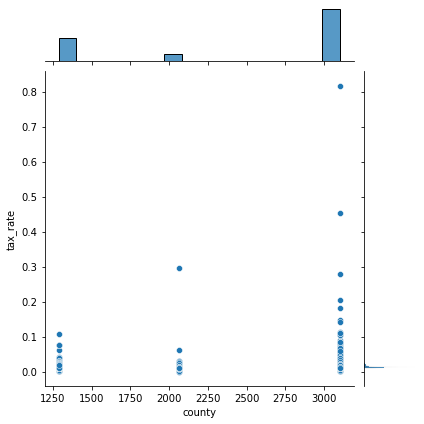

In [21]:
# here I would like to answer the stakeholders request for the distribution of tax_rate by county
sns.jointplot(x=df["county"], y=df["tax_rate"], kind='scatter')

so we can inform the stakeholders that in county 3101 the tax rate is the highest on average, followed by county 1286 and then the lowest tax_rate exists in county 2061

In [22]:
# here is where I found the label for each county above
df.county.value_counts()

3101.0    17886
1286.0     7740
2061.0     2434
Name: county, dtype: int64

In [23]:
# time to check for duplicates and remove them
# dropping ALL duplicate values
df.drop_duplicates(subset ="parcel_id",
                     keep = False, inplace = True)
 

In [24]:
# here we can see with shape that numerous duplicate rows were dropped
df.shape

(28017, 11)

In [28]:
# let's get rid of the unnecessary decimal point
#df['beds','sqft','tax_value','assessment_year','county','zipcode'] = df['beds','sqft','tax_value','assessment_year','county','zipcode'].astype(str).apply(lambda x: x.replace('.0',''))
df['beds'] = df['beds'].astype(str).apply(lambda x: x.replace('.0',''))

In [29]:
df['sqft'] = df['sqft'].astype(str).apply(lambda x: x.replace('.0',''))

In [30]:
df['tax_value'] = df['tax_value'].astype(str).apply(lambda x: x.replace('.0',''))

In [31]:
df['assessment_year'] = df['assessment_year'].astype(str).apply(lambda x: x.replace('.0',''))

In [32]:
df['county'] = df['county'].astype(str).apply(lambda x: x.replace('.0',''))

In [ ]:
df['zipcode'] = df['zipcode'].astype(str).apply(lambda x: x.replace('.0',''))

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28017 entries, 0 to 28123
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        28017 non-null  int64  
 1   beds             28017 non-null  object 
 2   baths            28017 non-null  float64
 3   sqft             28017 non-null  object 
 4   tax_value        28017 non-null  object 
 5   taxamount        28017 non-null  float64
 6   assessment_year  28017 non-null  object 
 7   county           28017 non-null  object 
 8   zipcode          28017 non-null  float64
 9   tranaction_date  28017 non-null  object 
 10  tax_rate         28017 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 2.6+ MB


In [ ]:
# check to see all decimals show how I would like
df.head()

In [36]:
# now let's tranform the columns back to the correct dtype
df.parcel_id = df.parcel_id.astype(object)

In [37]:
df.beds = df.beds.astype(int)

In [38]:
df.sqft = df.sqft.astype(int)

In [ ]:
df.tax_amount = df.tax_amount.astype(int)

In [39]:
# here I am going to check for error values in the df
df.beds.value_counts()
# these seem reasonable for bedroom count so lets move on

3     12535
4      8266
2      4333
5      2138
6       340
1       311
7        50
0        30
8         7
9         4
10        2
11        1
Name: beds, dtype: int64

In [40]:
df.baths.value_counts()
# these numbers also seem reasonable for number of bathrooms

2.0     11693
3.0      5782
1.0      4895
2.5      2206
4.0      1195
3.5       538
1.5       451
5.0       440
4.5       384
6.0       174
5.5       111
7.0        51
8.0        29
6.5        27
0.0        23
7.5         9
9.0         5
11.0        2
10.0        1
8.5         1
Name: baths, dtype: int64

In [41]:
# changing the datatype back to a float
df.sqft = df.sqft.astype(float, copy=False)

In [42]:
# checking for any homes under 300 sqft because this could be an erroneous entry
df[df['sqft']< 300]

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date,tax_rate
20070,11915330,0,1.0,240.0,380000,5222.26,2016,3101,96515.0,2017-07-19,0.013743


In [ ]:
# this only returned one location and this could be a tiny home so I have decided it is not an error value so I'll 
# keep it

In [43]:
# time to split up my df into train, validate, test and set my target
target = 'tax_value'

In [44]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df, target)

In [ ]:
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns train, validate, test sets and also another 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [ ]:
b = np.where(df.sqft < 300)
print(b)

In [45]:
# now I am checking to make sure they are all the same shape col wise

In [46]:
train.shape

(15689, 11)

In [47]:
validate.shape

(6724, 11)

In [48]:
test.shape

(5604, 11)

In [49]:
# now it's time to prep train2 for explore
train2 = train.copy()

In [76]:
#remove any column leaking the target so taxamount and tax_rate
train2 = train.drop(columns=['taxamount', 'tax_rate','tax_value'])


In [77]:
train2.head()

,parcel_id,beds,baths,sqft,assessment_year,county,zipcode,tranaction_date
21625,14320513,3,2.0,1702.0,2016,1286,96940.0,2017-08-02
13705,14225051,4,2.5,2070.0,2016,1286,97063.0,2017-07-05
9147,12472121,3,1.0,1210.0,2016,3101,96212.0,2017-06-15
962,10807588,3,2.0,1700.0,2016,3101,96387.0,2017-05-03
26797,14249510,4,2.0,1412.0,2016,1286,97005.0,2017-08-24


<AxesSubplot:xlabel='beds'>

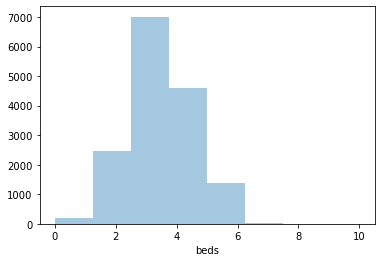

In [78]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=train2["beds"], bins=8, hist=True, kde=False, rug=False )

<AxesSubplot:xlabel='sqft'>

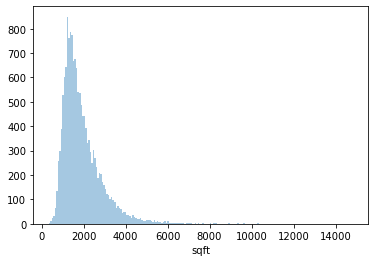

In [79]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=train2["sqft"], bins=200, hist=True, kde=False, rug=False )

(array([1.000e+00, 1.060e+02, 1.221e+03, 3.195e+03, 3.318e+03, 2.342e+03,
        1.666e+03, 1.195e+03, 8.680e+02, 5.620e+02, 3.890e+02, 2.420e+02,
        1.520e+02, 1.130e+02, 7.200e+01, 5.900e+01, 4.300e+01, 3.600e+01,
        2.300e+01, 2.100e+01, 9.000e+00, 1.000e+01, 7.000e+00, 5.000e+00,
        1.200e+01, 1.000e+00, 4.000e+00, 1.000e+00, 6.000e+00, 1.000e+00]),
 array([    0.        ,   333.33333333,   666.66666667,  1000.        ,
         1333.33333333,  1666.66666667,  2000.        ,  2333.33333333,
         2666.66666667,  3000.        ,  3333.33333333,  3666.66666667,
         4000.        ,  4333.33333333,  4666.66666667,  5000.        ,
         5333.33333333,  5666.66666667,  6000.        ,  6333.33333333,
         6666.66666667,  7000.        ,  7333.33333333,  7666.66666667,
         8000.        ,  8333.33333333,  8666.66666667,  9000.        ,
         9333.33333333,  9666.66666667, 10000.        ]),
 <BarContainer object of 30 artists>)

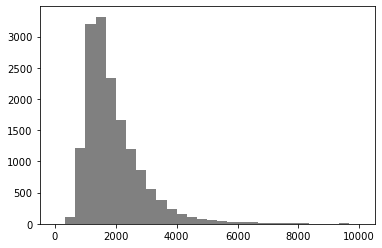

In [80]:
plt.hist(train2.sqft, 30, range=[0, 10000], facecolor='gray', align='mid')

<AxesSubplot:xlabel='county'>

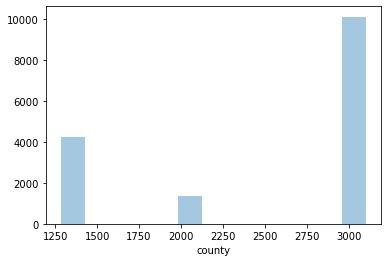

In [81]:
# Plot the histogram county
sns.distplot( a=train2["county"], hist=True, kde=False, rug=False )

<AxesSubplot:xlabel='zipcode'>

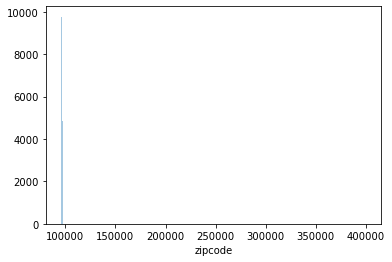

In [83]:
# Plot the histogram zipcode
sns.distplot( a=train2["zipcode"],bins=500,hist=True, kde=False, rug=False )

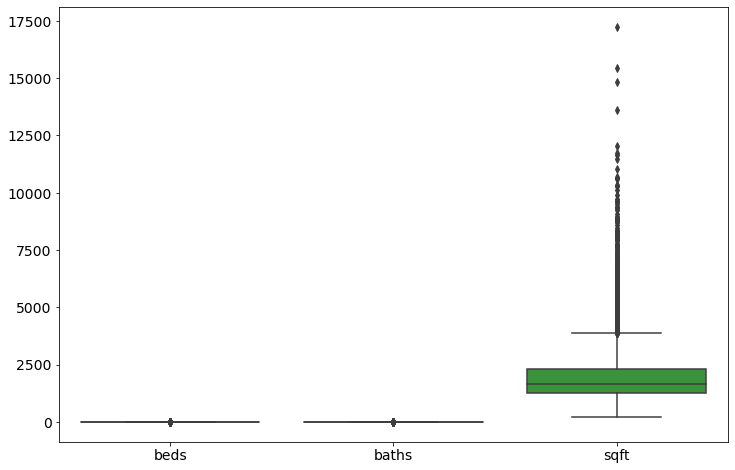

In [145]:
# We don't want to plot the 'pacel_id' column.

plt.figure(figsize=(12,8))

# Create boxplots for all but parcel_id, zipcode, tax_value, taxamount, tax_rate
sns.boxplot(data=df.drop(columns=['parcel_id','zipcode','tax_value','taxamount','tax_rate']))
plt.show()

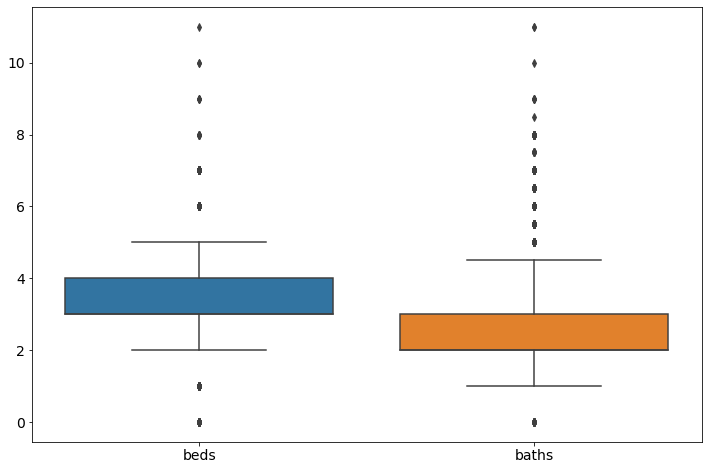

In [144]:
# create a boxplot for baths and beds so we can see them better
plt.figure(figsize=(12,8))

# Create boxplots for all but parcel_id.
sns.boxplot(data=df.drop(columns=['parcel_id','zipcode','tax_value','taxamount','sqft','tax_rate']))
plt.show()

In [58]:
# time to scale
num_cols = ['beds','baths','sqft']
def use_min_max(X_train, X_validate, X_test, num_col):
    '''
    this function takes in X: train, validate, and test
    a list of numeric column names that were specified to use in the first go round of estimation,
    and fits a min-max scaler to the first dataframe only and then transforms all
    dataframes using this scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = MinMaxScaler(copy=True).fit(X_train[num_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[num_cols])
    X_validate_scaled_array = scaler.transform(X_validate[num_cols])
    X_test_scaled_array = scaler.transform(X_test[num_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=num_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=num_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=num_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

ConversionError: Failed to convert value(s) to axis units: array(['2016', '2016', '2016', ..., '2016', '2016', '2016'], dtype=object)

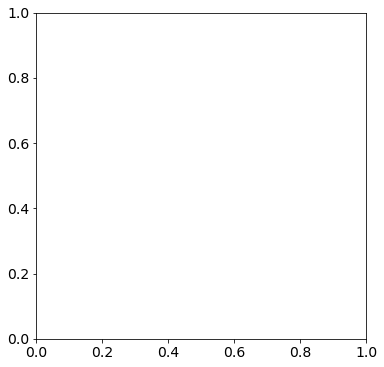

In [149]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.drop(columns='zipcode'), bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled.drop(columns='zipcode'), bins=25, ec='black')
plt.title('Scaled')

In [59]:
use_min_max(X_train, X_validate, X_test, num_cols)

(       beds     baths      sqft
 21625   0.3  0.181818  0.094877
 13705   0.4  0.227273  0.120251
 9147    0.3  0.090909  0.060953
 962     0.3  0.181818  0.094739
 26797   0.4  0.181818  0.074881
 ...     ...       ...       ...
 2565    0.3  0.181818  0.072123
 6673    0.3  0.090909  0.086051
 16329   0.4  0.181818  0.092533
 12981   0.3  0.181818  0.085569
 5948    0.3  0.272727  0.089361
 
 [15689 rows x 3 columns],
        beds     baths      sqft
 20338   0.4  0.272727  0.214232
 16152   0.3  0.090909  0.061987
 9769    0.4  0.272727  0.138454
 8852    0.2  0.090909  0.043853
 22535   0.2  0.136364  0.051989
 ...     ...       ...       ...
 24514   0.3  0.181818  0.063297
 25653   0.3  0.090909  0.047783
 9190    0.4  0.272727  0.148314
 17163   0.4  0.272727  0.121906
 4253    0.4  0.181818  0.113287
 
 [6724 rows x 3 columns],
        beds     baths      sqft
 12448   0.3  0.181818  0.083776
 711     0.3  0.363636  0.190581
 2278    0.3  0.181818  0.069365
 8922    0.3  0.181

##Takeaways from Prepare
df is prepped and ready to answer questions posed
X_train, etc. is prepped and ready for explore
there were no outliers in the dataset after cleaning and whittling it down

examples
exam1 has 1 Null value.
exam1 should likely be of type int64 once the Null value is addressed.
There is likely an odd value in exam3, as it should be of type int64 but was read in as an object. We need to find that value.
Given that there are limited attributes and limited observations with missing values, dropping the observations with missing values is probably a good way to go here

In [ ]:
######## EXPLORE ############

Hypothesis 1: Let's see if there is a relationship between sqft and tax_value.

alpha = .05

$H_0$: There is no relationship between sqft and tax_value, they are independent. 

$H_a$: There is a relationship between sqft and tax_value, they are dependent on each other.



Hypothesis 2: Let's see if there is a relationship between baths and tax_value.

alpha = .05

$H_0$: There is no relationship between baths and tax_value, they are independent. 

$H_a$: There is a relationship between baths and tax_value, they are dependent on each other.



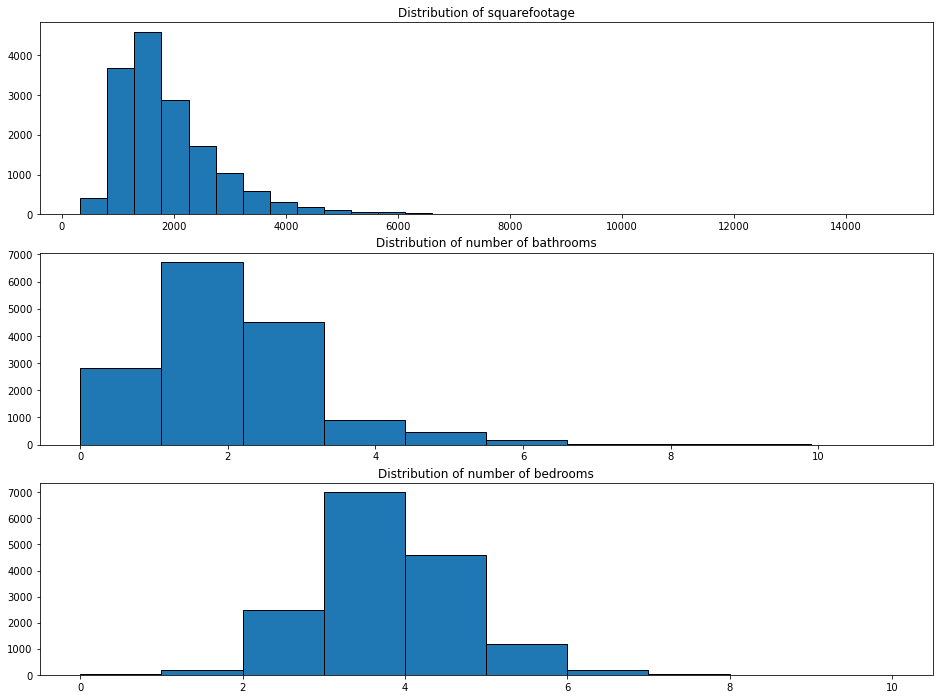

In [84]:
# plot histograms
plt.figure(figsize=(16,12))
plt.subplot(3,1,1, title='Distribution of squarefootage')
plt.hist(data=train2, x='sqft', bins = 30,ec='black')

plt.subplot(3,1,2, title='Distribution of number of bathrooms')
plt.hist(data=train2, x='baths', ec='black')

plt.subplot(3,1,3, title='Distribution of number of bedrooms')
plt.hist(data=train2, x='beds',ec='black')

plt.show()

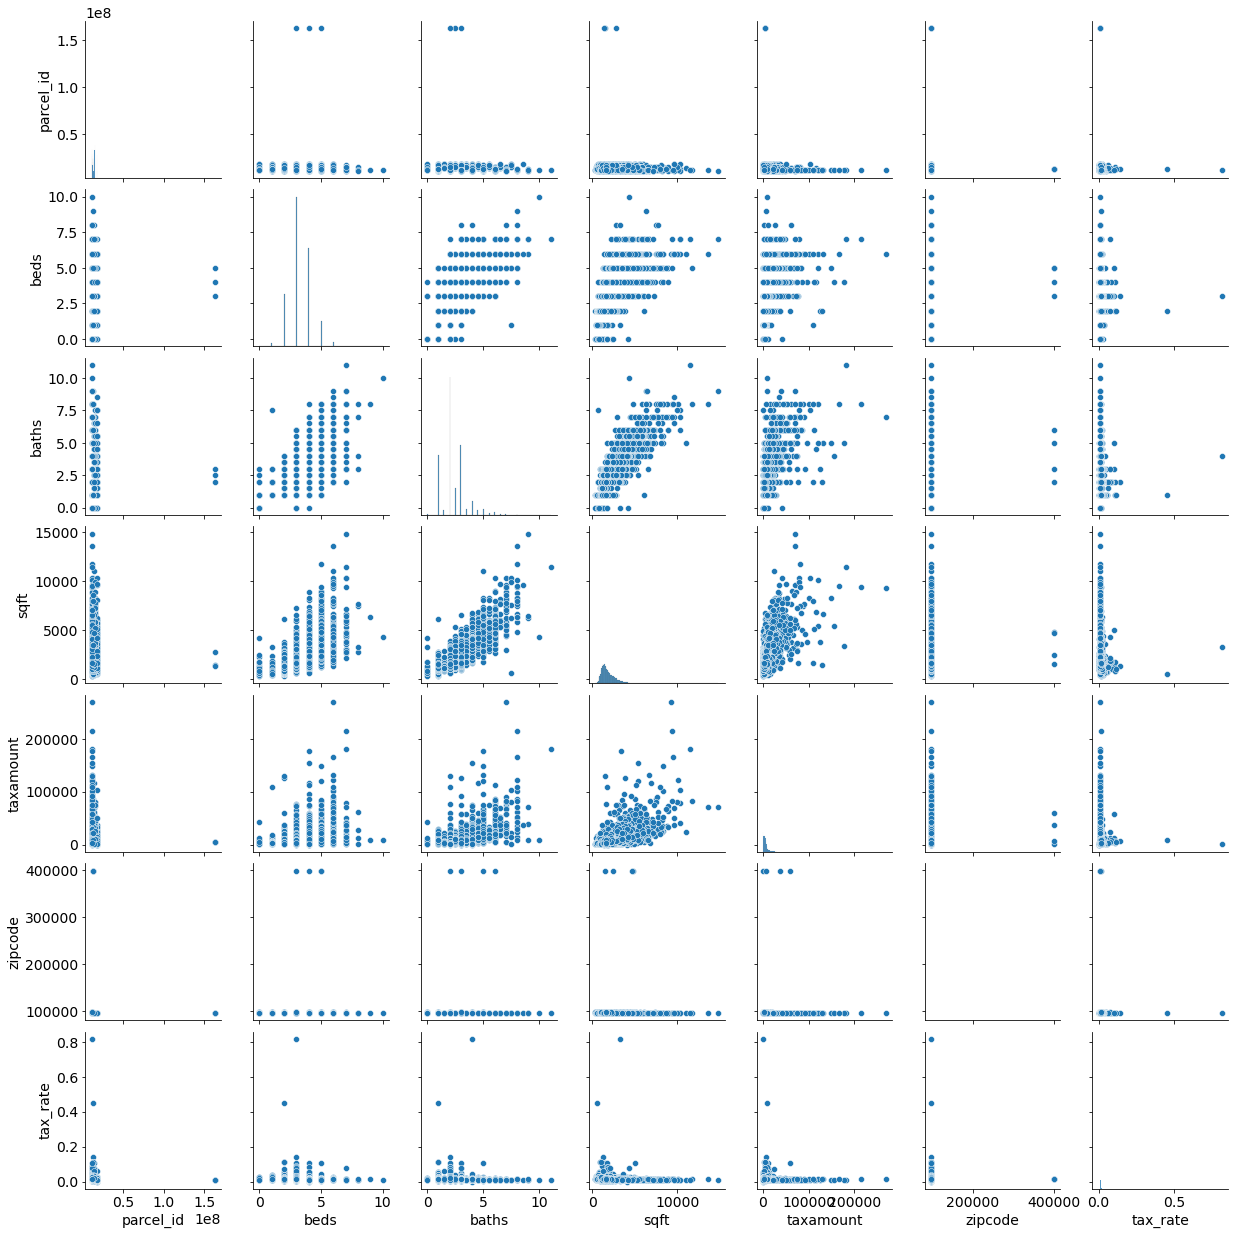

In [134]:
#make a pairpolot
sns.pairplot(train)

In [ ]:
** Takeaway from pair plot


In [86]:
# create a correlation table
train2.corr()

,beds,baths,sqft,zipcode
beds,1.000000,0.643529,0.628442,0.031140
baths,0.643529,1.000000,0.852234,0.038193
sqft,0.628442,0.852234,1.000000,0.032677
zipcode,0.031140,0.038193,0.032677,1.000000


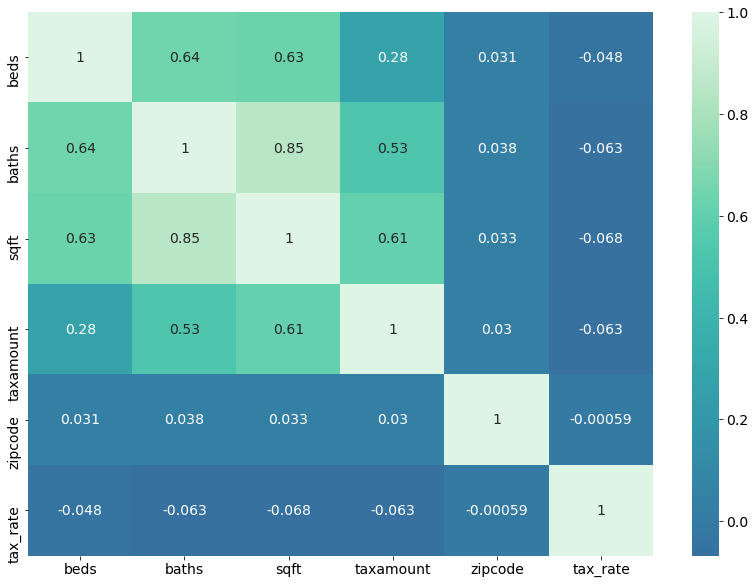

In [135]:
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))
sns.heatmap(train.corr(), cmap='mako', center=0, annot=True)
plt.show()

In [ ]:
# the heatmap shows me there is strong correlation between baths and sqft

In [93]:
y_train.head()

21625    654566
13705    644683
9147     332567
962      660000
26797    305756
Name: tax_value, dtype: object

In [95]:
#sns.catplot(data=train2, x=y_train, y='county', kind='strip')

In [ ]:
sns.relplot(data=train2, x='baths', y='sqft', kind='scatter', hue=, col=y_train)

In [98]:
# Next I'll display some pairplots
sns.pairplot(train, hue=train.tax_amount)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'tax_amount'

In [103]:
### Univariate

def explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = freq_table(train, cat_var)
    plt.figure(figsize=(2,2))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats
    
def freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table

In [104]:
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)

In [114]:
train.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date,tax_rate
21625,14320513,3,2.0,1702.0,654566,6695.28,2016,1286,96940.0,2017-08-02,0.010229
13705,14225051,4,2.5,2070.0,644683,7008.44,2016,1286,97063.0,2017-07-05,0.010871
9147,12472121,3,1.0,1210.0,332567,4186.39,2016,3101,96212.0,2017-06-15,0.012588
962,10807588,3,2.0,1700.0,660000,8096.32,2016,3101,96387.0,2017-05-03,0.012267
26797,14249510,4,2.0,1412.0,305756,3431.12,2016,1286,97005.0,2017-08-24,0.011222


In [115]:
cat_vars = ['zipcode','county']
quant_vars = ['beds','baths','sqft']

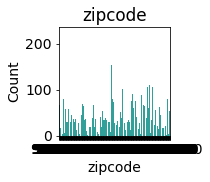

         zipcode  Count  Percent
97319.0  96940.0    225     1.43
97318.0  97063.0    191     1.22
97329.0  96212.0    175     1.12
97118.0  96387.0    167     1.06
96987.0  97005.0    160     1.02
...          ...    ...      ...
96002.0  96021.0      1     0.01
96148.0  97108.0      1     0.01
97108.0  97119.0      1     0.01
96323.0  96226.0      1     0.01
96467.0  96002.0      1     0.01

[376 rows x 3 columns]
_________________________________________________________________


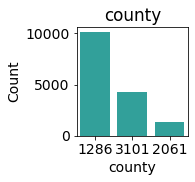

     county  Count  Percent
3101   1286  10101    64.38
1286   3101   4235    26.99
2061   2061   1353     8.62
_________________________________________________________________


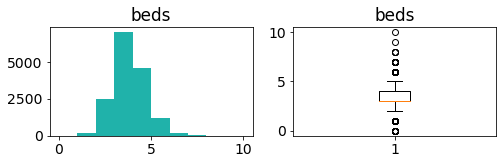

count    15689.000000
mean         3.307094
std          0.929790
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: beds, dtype: float64


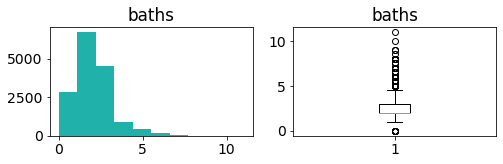

count    15689.000000
mean         2.312321
std          1.016552
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: baths, dtype: float64


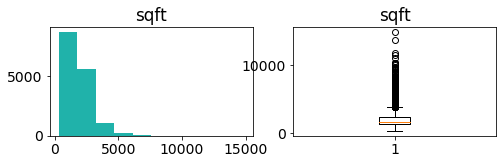

count    15689.000000
mean      1928.589585
std        993.874633
min        326.000000
25%       1277.000000
50%       1667.000000
75%       2313.000000
max      14829.000000
Name: sqft, dtype: float64


In [116]:
explore_univariate(train, cat_vars, quant_vars)

In [ ]:
# bivariate

In [117]:
#### Bivariate
target = 'tax_value'
def explore_bivariate_categorical(train, target, cat_var):
    '''
    takes in categorical variable and binary target variable, 
    returns a crosstab of frequencies
    runs a chi-square test for the proportions
    and creates a barplot, adding a horizontal line of the overall rate of the target. 
    '''
    print(cat_var, "\n_____________________\n")
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2_summary, observed, expected = run_chi2(train, cat_var, target)
    p = plot_cat_by_target(train, target, cat_var)
    
    print(chi2_summary)
    print("\nobserved:\n", ct)
    print("\nexpected:\n", expected)
    plt.show(p)
    print("\n_____________________\n")

def explore_bivariate_quant(train, target, quant_var):
    '''
    descriptive stats by each target class. 
    compare means across 2 target groups 
    boxenplot of target x quant
    swarmplot of target x quant
    '''
    print(quant_var, "\n____________________\n")
    descriptive_stats = train.groupby(target)[quant_var].describe()
    average = train[quant_var].mean()
    mann_whitney = compare_means(train, target, quant_var)
    plt.figure(figsize=(4,4))
    boxen = plot_boxen(train, target, quant_var)
    swarm = plot_swarm(train, target, quant_var)
    plt.show()
    print(descriptive_stats, "\n")
    print("\nMann-Whitney Test:\n", mann_whitney)
    print("\n____________________\n")

## Bivariate Categorical

def run_chi2(train, cat_var, target):
    observed = pd.crosstab(train[cat_var], train[target])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

def plot_cat_by_target(train, target, cat_var):
    p = plt.figure(figsize=(2,2))
    p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
    overall_rate = train[target].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p
    

## Bivariate Quant

def plot_swarm(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.swarmplot(data=train, x=target, y=quant_var, color='lightgray')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

def plot_boxen(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.boxenplot(data=train, x=target, y=quant_var, color='lightseagreen')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

# alt_hyp = ‘two-sided’, ‘less’, ‘greater’

def compare_means(train, target, quant_var, alt_hyp='two-sided'):
    x = train[train[target]==0][quant_var]
    y = train[train[target]==1][quant_var]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)

def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)


In [119]:
#explore_bivariate(train, target, cat_vars, quant_vars)

In [ ]:
# the results of the bivariate 
# chi2 test shows a very low p value indicating a very likely correlation between baths and tax_value

In [120]:
# check for relationship between zipcode and tax_value
run_chi2(train, 'zipcode', target)

(           chi2       p-value  degrees of freedom
 0  5.118253e+06  2.082137e-28             5083125,
 tax_value  1000  100000  1000000  100063  100073  1001170  1001346  100155  \
 zipcode                                                                      
 95982.0       0       0        0       0       0        0        0       0   
 95983.0       0       0        0       0       0        0        0       0   
 95984.0       0       0        0       0       0        0        0       0   
 95985.0       0       0        0       0       0        0        0       0   
 95986.0       0       0        0       0       0        0        0       0   
 ...         ...     ...      ...     ...     ...      ...      ...     ...   
 97329.0       0       0        0       0       0        0        0       0   
 97330.0       0       0        0       0       0        0        0       0   
 97331.0       0       0        0       0       0        0        0       0   
 97344.0       0       0    

In [ ]:
# chi2 test shows a very low p value indicating a very likely correlation between zipcode and tax_value

In [121]:
# check for relationship between county and tax_value
run_chi2(train, 'county', target)

(           chi2       p-value  degrees of freedom
 0  28408.781952  1.965699e-08               27110,
 tax_value  1000  100000  1000000  100063  100073  1001170  1001346  100155  \
 county                                                                       
 1286          0       0        0       0       0        0        1       1   
 2061          0       0        0       0       0        1        0       0   
 3101          1       1        2       1       1        0        0       0   
 
 tax_value  100194  1002082  ...  998420  99843  99869  999287  999289  99981  \
 county                      ...                                                
 1286            0        0  ...       0      1      0       0       0      0   
 2061            0        0  ...       0      0      0       1       0      0   
 3101            1        1  ...       1      0      1       0       1      1   
 
 tax_value  99985  999900  99991  999937  
 county                                   
 1286  

In [ ]:
# chi2 test shows a very low p value indicating a very likely correlation between county and tax_value

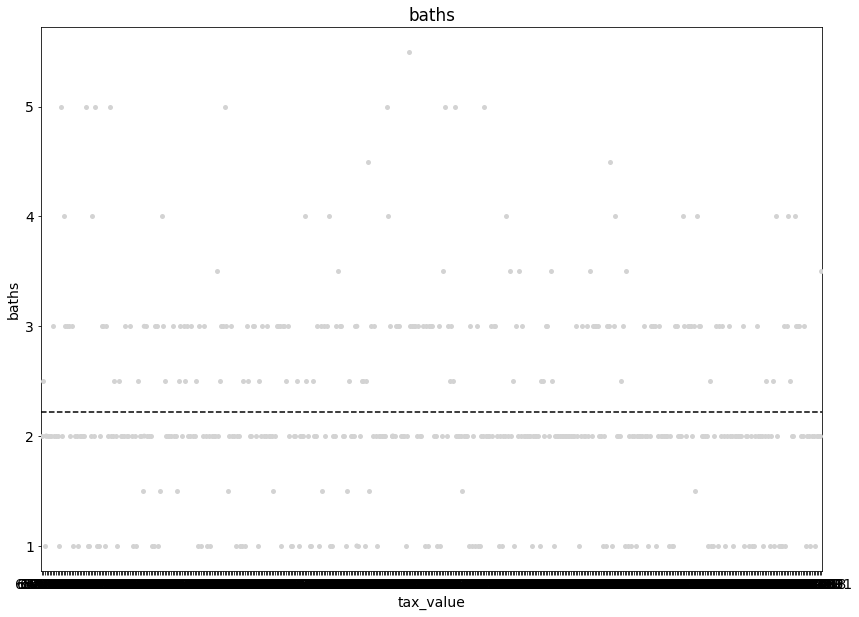

In [125]:
plot_swarm(train.head(500), target, 'baths')

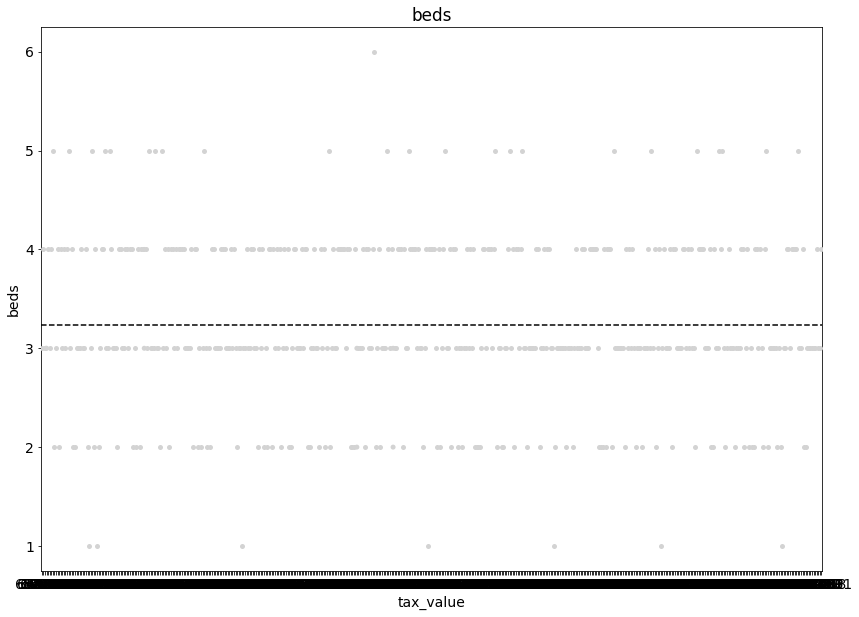

In [126]:
plot_swarm(train.head(500), target, 'beds')

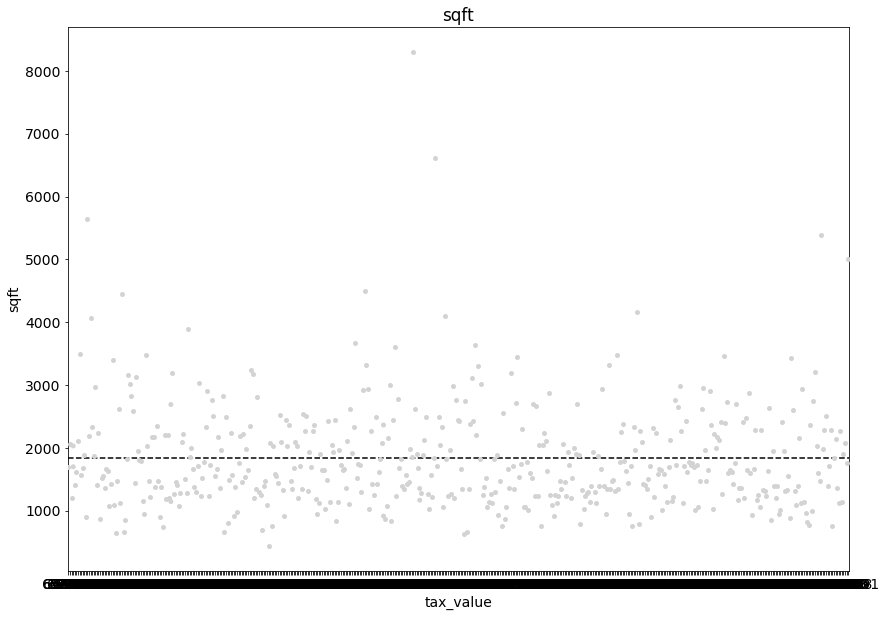

In [127]:
plot_swarm(train.head(500), target, 'sqft')

In [ ]:
## multivariate

In [128]:
## Multivariate

def plot_all_continuous_vars(train, target, quant_vars):
    '''
    Melt the dataset to "long-form" representation
    boxenplot of measurement x value with color representing the target variable. 
    '''
    my_vars = [item for sublist in [quant_vars, [target]] for item in sublist]
    sns.set(style="whitegrid", palette="muted")
    melt = train[my_vars].melt(id_vars=target, var_name="measurement")
    plt.figure(figsize=(8,6))
    p = sns.boxenplot(x="measurement", y="value", hue=target, data=melt)
    p.set(yscale="log", xlabel='')    
    plt.show()

def plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()
    
def plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

In [129]:
def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
    plot_all_continuous_vars(train, target, quant_vars)
    plt.show()    


KeyboardInterrupt: 

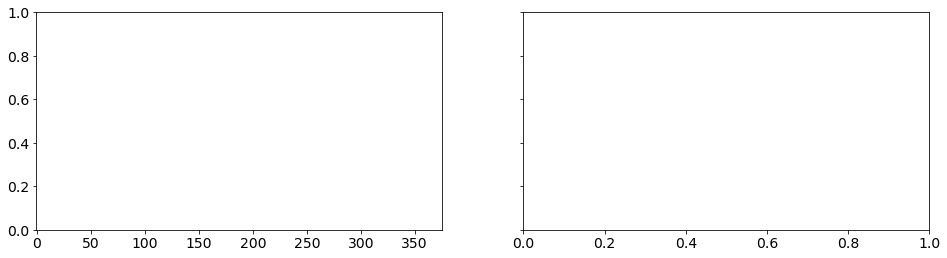

In [130]:
explore_multivariate(train, target, cat_vars, quant_vars)

TypeError: No loop matching the specified signature and casting was found for ufunc add

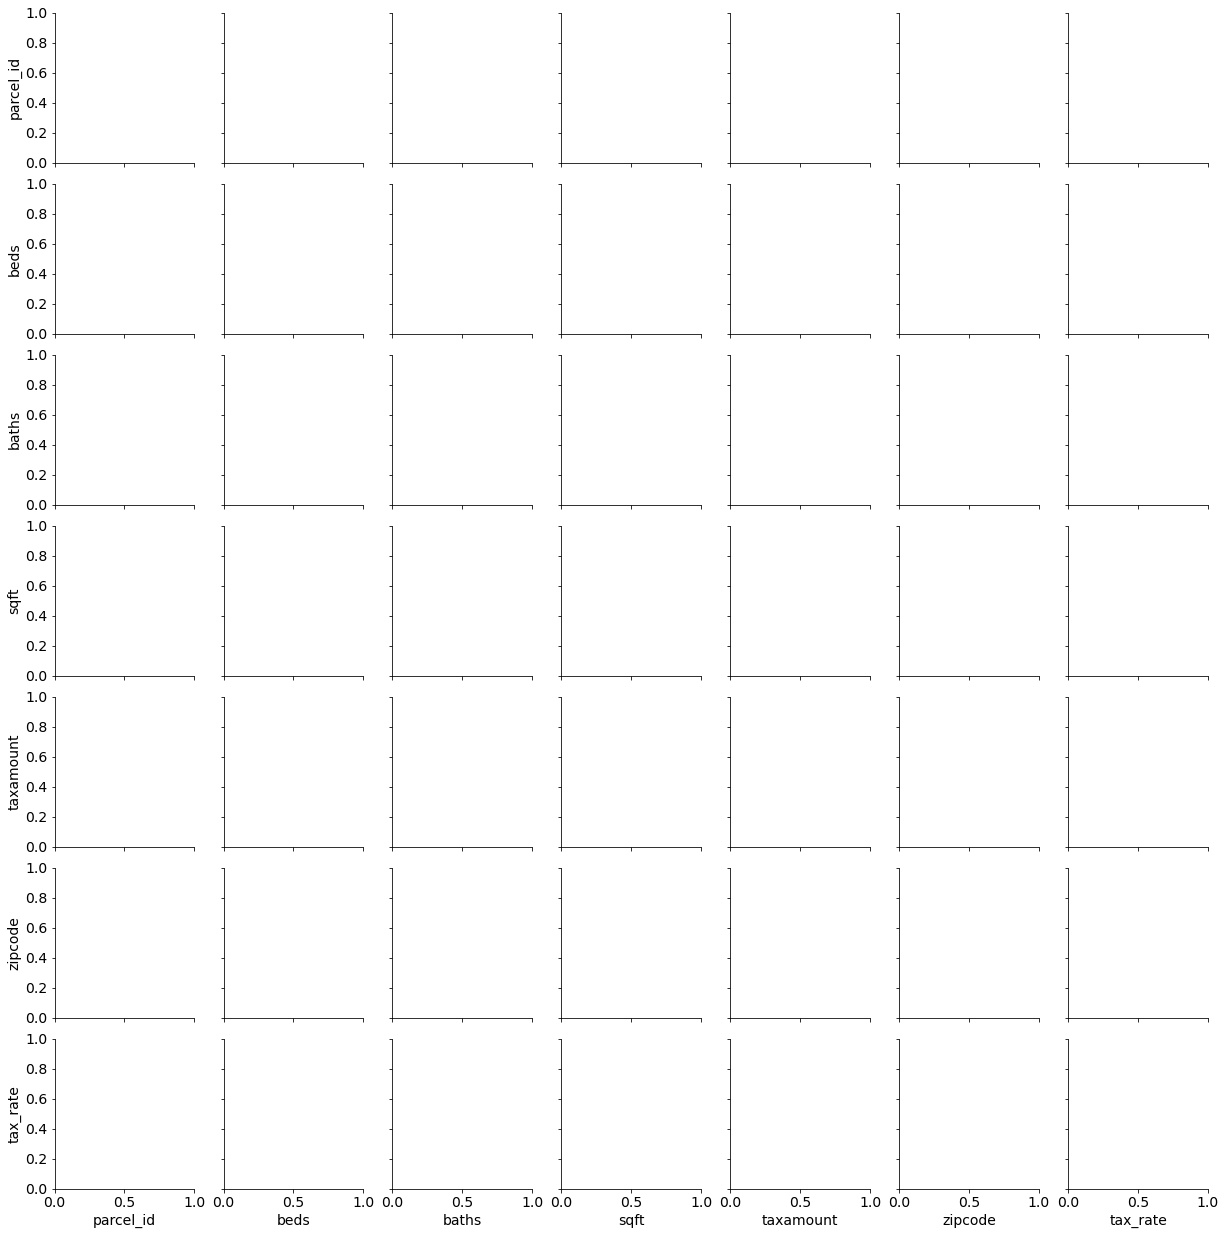

In [133]:
# Next I'll display some pairplots
sns.pairplot(train, hue='tax_value')
plt.show()

** Takeaways from explore





In [ ]:
##### Modeling #######

In [ ]:
#scaled df
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

In [ ]:
# establish the baseline

In [ ]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('BASELINE')
print('--------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('--------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
select_kbest(X_train_scaled, y_train,4)

In [ ]:
Additional thoughts

Identify if there are logical/domain/cultural cutoffs in continuous variables that would allow us to treat them as categorial values. For example, 98.45 and 99.1 are both an A or an A+ grade in most scales.
If there's a logical cutoff point, like a grade of 70 or a voting age of 18, we can make a boolean to go along with a continuous value. This can allow us to gain additional insight in visualizing distributions between groups.

In [ ]:
sns.pairplot()

Let's use sns.pairplot() to view a scatter plot visualizing the relationships between all of the numeric columns in our dataset all at once as well as individual distributions for each individual column.

# We can drop the redundant information in the upper right half of the chart if we like.

sns.pairplot(train[['exam1', 'exam2', 'exam3', 'final_grade']], corner=True)
plt.show()

In [ ]:
sns.jointplot()

Let's use a sns.jointplot() with kind=reg to view individual variable distributions for our x and y along with a scatter plot with regression line.

sns.jointplot(x="exam1", y="final_grade", data=train,  kind='reg', height=5)
plt.show()

In [ ]:
Let's do a simple scatter plot of two continuous variables in our dataset.

sns.relplot(x="exam1", y="final_grade", data=train)
plt.show()

In [ ]:
Let's make that simple scatter plot but add a regression line.

# I can really pop that line color if I want.

sns.lmplot(x="exam1", y="final_grade", data=train, line_kws={'color': 'red'})
plt.show()

In [ ]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.exam1, train.final_grade)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.9860332649385698
P-value: 1.0065104366972225e-43

In [ ]:
Test Your Hypotheses: Analyze the drivers of a continuous target variable using the appropriate statistical tests (t-tests, correlation, and chi-squared hypothesis tests).